# Обучение без учителя: метод главных компонент и кластеризация

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [8]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))



Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините X_train с X_test, а y_train – с y_test.


In [124]:
# Ваш код здесь
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
#или 
#X = np.vstack([X_train, X_test])
#y = np.hstack([y_train, y_test])

In [125]:
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [20]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [21]:
n_classes = np.unique(y).size


    1 - ходьбе
    2 - подъему вверх по лестнице
    3 - спуску по лестнице
    4 - сидению
    5 - стоянию
    6 - лежанию


Отмасштабируйте выборку с помощью StandardScaler с параметрами по умолчанию

In [149]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [150]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?<br>

In [151]:
#Ваш код здесь
X_pca.shape

(10299, 65)

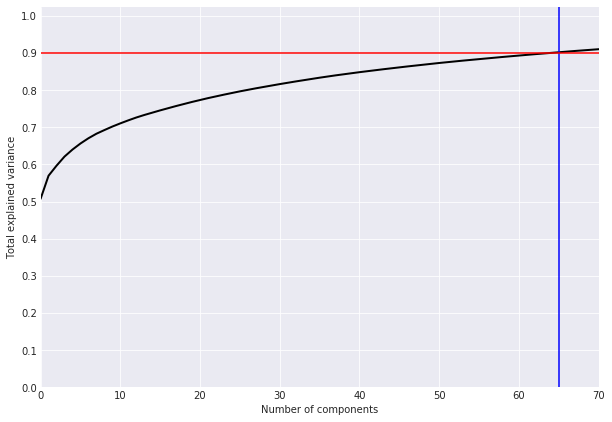

In [152]:
pca = PCA().fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 70)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(65, c='b')
plt.axhline(0.9, c='r')
plt.show();

Ответ(1): 65

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.<br>

In [136]:
a = np.cumsum(pca.explained_variance_ratio_)[0]

In [144]:
round(float(a*100))

51

Ответ(2): 51



Визуализируйте данные в проекции на первые две главные компоненты.


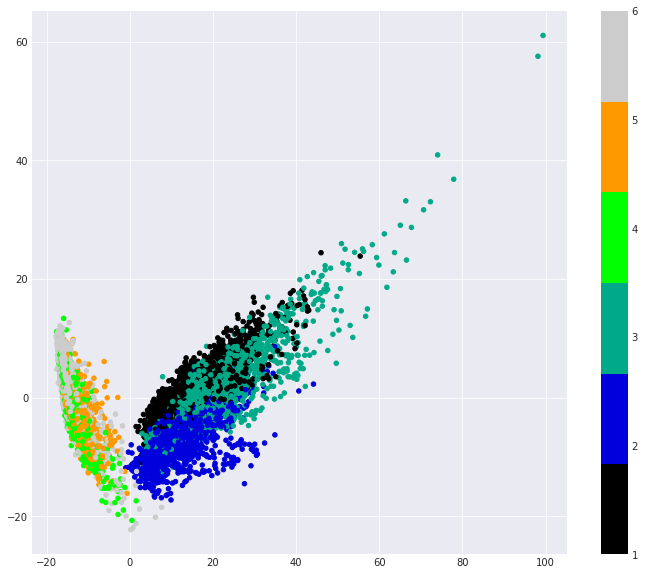

In [161]:
#pca = PCA(n_components=2)
#X_reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap=plt.cm.get_cmap('nipy_spectral', 6));#cmap='viridis');
plt.colorbar();

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

Ответ(3): 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

## T-SNE

Wall time: 3min 26s


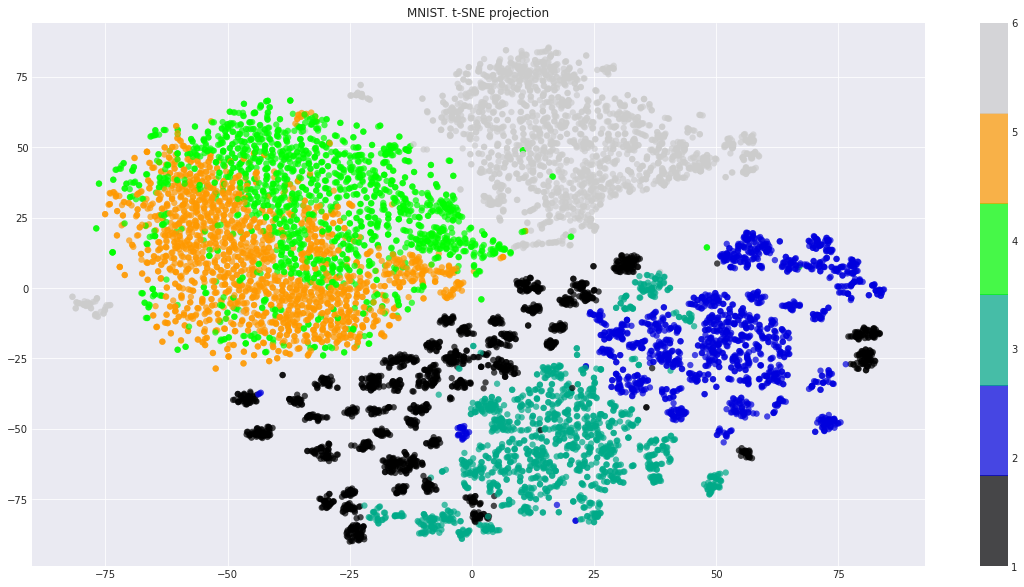

In [97]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(20,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

Wall time: 2min 51s


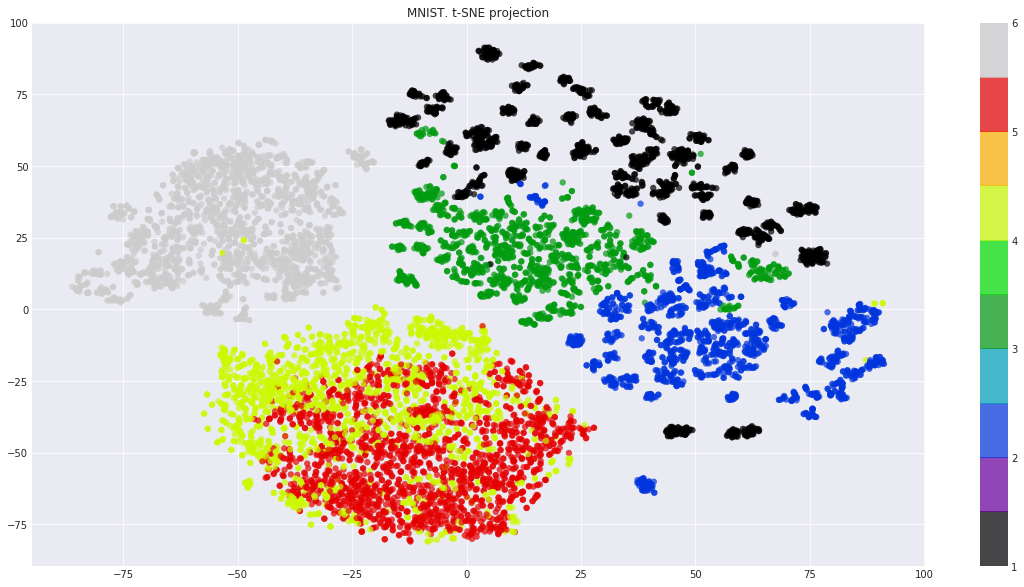

In [93]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(20,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

# K-MEANS



Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

In [203]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, 
                random_state=RANDOM_STATE, n_jobs=1)
kmeans.fit(X_pca)
kmeans_labels = kmeans.labels_+1

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

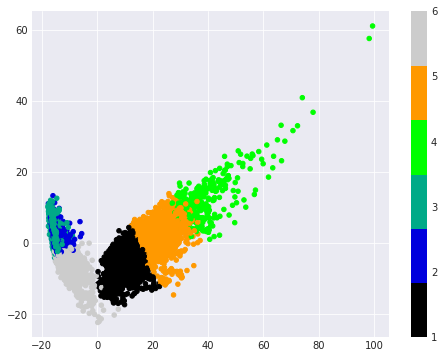

In [204]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],\
                    c=kmeans_labels, s=20,\
                    cmap=plt.cm.get_cmap('nipy_spectral', 6));#cmap='viridis');
plt.colorbar();



Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм KMeans путает.


In [280]:
tab = pd.crosstab(y, kmeans_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


In [177]:
#Хотьба:
903/1722

0.524390243902439

In [178]:
#стояние:
1344/1906

0.7051416579223505

In [179]:
#спуск по лестнице:
890/1406

0.6330014224751067

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой метрики, описанной выше?<br>

In [285]:
tab.iloc[:-1,:-1].max(axis=1).values

array([ 903, 1241,  890, 1235, 1344, 1558], dtype=int64)

In [287]:
tab.iloc[:-1,-1]

ходьба                      1722
подъем вверх по лестнице    1544
спуск по лестнице           1406
сидение                     1777
стояние                     1906
лежание                     1944
Name: все, dtype: int64

In [290]:
tab.index[:-1]

Index(['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение',
       'стояние', 'лежание'],
      dtype='object')

In [283]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1).values / 
          tab.iloc[:-1,-1].values, index=tab.index[:-1])

ходьба                      0.524390
подъем вверх по лестнице    0.803756
спуск по лестнице           0.633001
сидение                     0.694992
стояние                     0.705142
лежание                     0.801440
dtype: float64

Ответ(4): перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

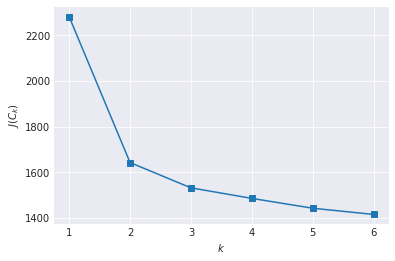

In [183]:
inertia = []
#for k in range(1, 8):
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, 
                random_state=RANDOM_STATE, n_jobs=1)
    kmeans.fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

Вычислим $D(k)$, как описано в [статье](https://habrahabr.ru/company/ods/blog/325654/) в части "Выбор числа кластеров для kMeans".

In [188]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [189]:
d

{2: 0.17344753560094187,
 3: 0.41688649539867606,
 4: 0.933215409447841,
 5: 0.6297040113715723}

Ответ(5): 2

# Агломеративная кластеризация

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [191]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [216]:
ag_labels = ag.labels_+1

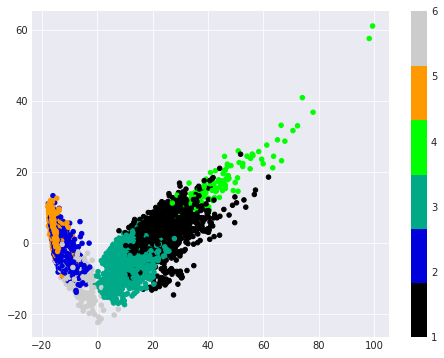

In [217]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],\
                    c=ag_labels, s=20,\
                    cmap=plt.cm.get_cmap('nipy_spectral', 6));#cmap='viridis');
plt.colorbar();

In [197]:
from sklearn.metrics.cluster import adjusted_rand_score

In [214]:
adjusted_rand_score(y, ag.labels_)

0.49362763373004886

In [212]:
adjusted_rand_score(y, kmeans.labels_)

0.4198070012602345

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

Ответ(6):
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering 
- Для ARI не имеет значения, какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры 
- В случае случайного разбиения на кластеры ARI будет близок к нулю 

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [218]:
# Ваш код здесь
scaler  = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [219]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [220]:
best_svc = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1)

In [246]:
%%time
best_svc.fit(X_train_scaled, y_train);

Wall time: 49.1 s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [226]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382480957562568)

**Вопрос 7:**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

Ответ(7): 0.1

In [227]:
y_predicted = best_svc.predict(X_test_scaled)

In [229]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,412,1,1,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,412,443,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

In [240]:
#подъем вверх по лестнице
print('Точность -',459/469)
print('Полнота -',459/471)

Точность - 0.9786780383795309
Полнота - 0.9745222929936306


In [236]:
#Ходьба
print('Точность -',494/508)
print('Полнота -',494/496)

Точность - 0.9724409448818898
Полнота - 0.9959677419354839


In [237]:
#Лежание
print('Точность -',526/526)
print('Полнота -',526/537)

Точность - 1.0
Полнота - 0.9795158286778398


In [244]:
#стояние
print('Точность -',517/589)
print('Полнота -',517/532)

Точность - 0.8777589134125636
Полнота - 0.9718045112781954


In [239]:
#сидение
print('Точность -',427/443)
print('Полнота -',427/491)

Точность - 0.963882618510158
Полнота - 0.869653767820774


Хуже всего:

In [241]:
#стояние
print('Точность -',517/589)
#сидение
print('Полнота -',427/491)

Точность - 0.8777589134125636
Полнота - 0.869653767820774


Ответ(8): по точности – стояние, по полноте – сидение 

In [243]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       496
           2       0.98      0.97      0.98       471
           3       1.00      0.98      0.99       420
           4       0.96      0.87      0.91       491
           5       0.88      0.97      0.92       532
           6       1.00      0.98      0.99       537

   micro avg       0.96      0.96      0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

In [247]:
scaler  = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [270]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [271]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [274]:
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1)

In [278]:
#%%time
#best_svc.fit(X_train_scaled, y_train)

In [279]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382480957562568)

In [275]:
%%time
best_svc_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   11.3s finished


Wall time: 12.8 s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [276]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 0.1}, 0.8986670293797606)

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

In [277]:
round(float(best_svc.best_score_ - best_svc_pca.best_score_)*100)

4

Ответ(9): 4%

**Вопрос 10:**<br>
Выберите все верные утверждения:

- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность 
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком 